In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
import pickle
from sklearn.linear_model import RANSACRegressor

alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_csv('../data/raw/train_cax.csv')
df_test = pd.read_csv('../data/raw/test_cax.csv')
df_train.head()

row_id  well_id          GR  label
0       0        0  143.510000      0
1       1        0  112.790928      0
2       2        0  123.531856      0
3       3        0  111.692784      0
4       4        0  123.613712      0

In [2]:
# for k,v in results[f'data_dict_train_{fold}'].items():
#     print(k,v.mean(),v.std())
# print('Test')
# for k,v in results[f'data_dict_test_{fold}'].items():
#     print(k,v.mean(),v.std())


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def rescale_one_row(s,q=0.4):
    # Detrend with robust LM model
    top = np.quantile(s,q)
    print(f'Selecting above {top}')
    x = np.arange(s.shape[0])
    idx = s>top
    x_fit=x[idx].reshape(-1,1)
    s_fit=s[idx].reshape(-1,1)
    model = make_pipeline(PolynomialFeatures(degree=1),RANSACRegressor(min_samples=250))
    model.fit(x_fit,s_fit)
    s_new = s.reshape(-1,1) -model.predict(x.reshape(-1,1))
    
    # now scale to -0.5,0.5 
    top = np.quantile(s_new,0.7)
    bottom = np.quantile(s_new,0.05)
    new_row = (s_new - bottom) / (top - bottom) - 0.5
    
    return new_row

def rescale_X_to_maxmin(X,note='note'):
    print(f'Performing a rescale on {note}..')
    for i in range(X.shape[0]):
        X[i,:] = rescale_one_row(X[i,:])
    return X

Selecting above 108.31776057267366
132.05164695177436 51.92718916433569


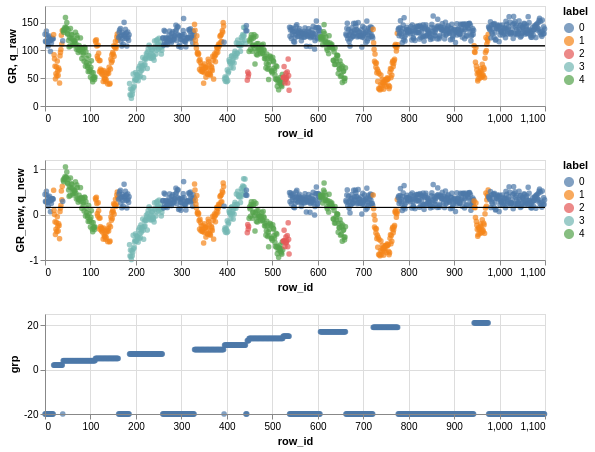

In [13]:
well_ids = df_train.sample(1)['well_id']
q=0.4
df_sub = df_train[df_train['well_id'].isin(well_ids)].copy()
df_sub['row_id'] = np.arange(df_sub.shape[0])
df_sub['GR_new'] = rescale_one_row(df_sub['GR'].values,q=q)
df_sub['grp'] = (df_sub['label']!=df_sub['label'].shift(1)).cumsum().fillna('pad')
df_sub.loc[df_sub['label'] == 0 ,'grp'] = -20
rand_grp_shift = np.random.uniform(-0.25,0.25,df_sub['grp'].unique().shape[0])
map_grp = dict(zip(df_sub['grp'].unique(),rand_grp_shift))
df_sub['GR_shift'] = df_sub['grp'].apply(lambda x: map_grp[x])
df_sub['GR_new'] = df_sub['GR_new'] + df_sub['GR_shift']

#df_sub['GR_high'] = df_sub['GR'][df_sub['GR']>100]
#df_sub['GR_new'] = df_sub['GR_high'].rolling(200,center=True,min_periods=100,).quantile(0.7)

df_quantile = pd.DataFrame({'q_raw':np.quantile(df_sub['GR'],q),'q_new':np.quantile(df_sub['GR_new'],q)},index=[0,1])

w=500
ch_gr = alt.Chart(df_sub,height=100,width=w).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_rule = alt.Chart(df_quantile).encode(y='q_raw').mark_rule()
ch_rule_new = alt.Chart(df_quantile).encode(y='q_new').mark_rule()

ch_gr_new = alt.Chart(df_sub,height=100,width=w).encode(x='row_id',y='GR_new',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_gr_nocol =alt.Chart(df_sub,height=100,width=w).encode(x='row_id',y='grp',order='row_id').mark_point(size=30,filled=True)
mu0 = df_sub[df_sub['label']==0]['GR'].median()
mu2 = df_sub[df_sub['label']==2]['GR'].median()
print(mu0,mu2)
( (ch_gr + ch_rule) & (ch_gr_new + ch_rule_new) & ch_gr_nocol ).resolve_scale(color='independent')

### Check the linear trend in data per class 0 per well - is it the same slope, or is there any variation?

In [52]:
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
slopes=[]
intercepts=[]
wells = df_train.sample(300)['well_id'].unique()
for w in tqdm(wells):
    df_sub = df_train[df_train['well_id'] == w]
    X = df_sub[df_sub['label'] == 0]['row_id'].values.reshape(-1,1)
    X_all = df_sub['row_id'].values.reshape(-1,1)
    y_all = df_sub['GR'].values.reshape(-1,1)
    y = df_sub[df_sub['label'] == 0]['GR'].values.reshape(-1,1)
    lm=RANSACRegressor()
    lm_all = RANSACRegressor()
    lm.fit(X,y)
    lm_all.fit(X_all,y_all)
    #print(f' Intercept fulldata = {lm_all.estimator_.intercept_[0]:.3f} , coef fulldata = {lm_all.estimator_.coef_[0][0]:.3f} ')
    #print(f' Intercept = {lm.estimator_.intercept_[0]:.3f} , coef = {lm.estimator_.coef_[0][0]:.3f} ')
    slope = lm_all.estimator_.coef_[0][0]
    intercept = lm_all.estimator_.intercept_[0]
    slopes.append(slope)
    intercepts.append(intercept)

100%|██████████| 286/286 [00:06<00:00, 44.61it/s]


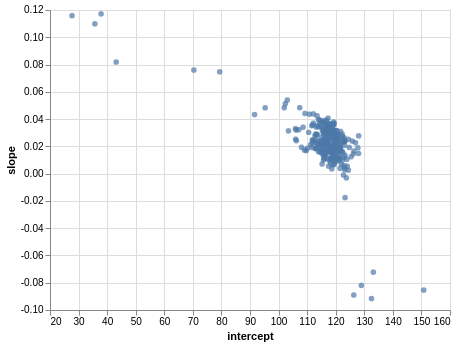

In [53]:
df_lm = pd.DataFrame({'slope':slopes,'intercept':intercepts})
alt.Chart(df_lm).encode(x=alt.X('intercept',scale=alt.Scale(zero=False)),y='slope').mark_point(filled=True)

# Create a rescale function:

row_id  well_id          GR  label
711700       0      647  126.403387      0
711701       1      647  111.130278      0
711702       2      647  110.522616      0
711703       3      647  112.896474      0
711704       4      647  116.175508      0
...        ...      ...         ...    ...
712795    1095      647  117.067829      0
712796    1096      647  113.931818      0
712797    1097      647  105.782336      0
712798    1098      647  107.902262      0
712799    1099      647  119.235098      0

[1100 rows x 4 columns]

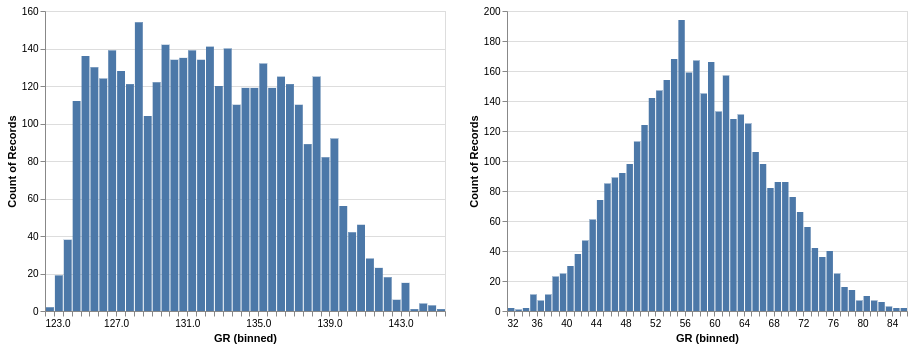

In [71]:
x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].mean().to_frame()
x2 = df_train[df_train['label']==2].groupby('well_id')['GR'].mean().to_frame()

df_train_new = df_train.copy().join(x0.reset_index(),rsuffix='_0',on='well_id').drop(columns ='well_id_0')
df_train_new = df_train_new.join(x2.reset_index(),rsuffix='_2',on='well_id').drop(columns ='well_id_2')

c2 = alt.Chart(x2).encode(x=alt.X('GR',bin=alt.Bin(maxbins=100)),y='count()').mark_bar()
c0 =alt.Chart(x0).encode(x=alt.X('GR',bin=alt.Bin(maxbins=100)),y='count()').mark_bar()

c0 | c2 

[[0.04451357]] [50.63932436]


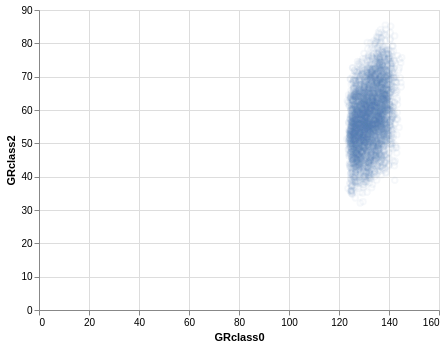

In [91]:
df_joint = pd.merge(x0,x2,on='well_id',suffixes=('class0','class2'))
ch_joint = alt.Chart(df_joint).encode(x='GRclass0',y='GRclass2').mark_point(opacity=0.05)
lm = RANSACRegressor()
lm.fit(df_joint['GRclass0'].values.reshape(-1,1),df_joint['GRclass2'].values.reshape(-1,1))
print(lm.estimator_.coef_,lm.estimator_.intercept_)
ch_joint
#df_merged_means

[[0.62632786]] [-25.62367388]


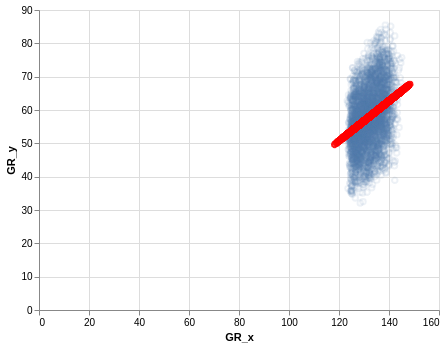

In [90]:
from sklearn.linear_model import RANSACRegressor

# For train
x_up = df_train.groupby('well_id')['GR'].quantile(0.715)
df_joint = pd.merge(x0.reset_index(),x2.reset_index(),on='well_id',how='right').dropna()
df_joint_fake = pd.DataFrame({'GR_x':x_up.values,'GR_y':0.6*x_up.values -21.3})
ch_joint = alt.Chart(df_joint).encode(x='GR_x',y='GR_y').mark_point(opacity=0.1)
ch_joint_fake = alt.Chart(df_joint_fake).encode(x='GR_x',y='GR_y',color=alt.value('red')).mark_point(opacity=0.9)
lm = RANSACRegressor()
lm.fit(df_joint['GR_x'].values.reshape(-1,1),df_joint['GR_y'].values.reshape(-1,1))
print(lm.estimator_.coef_,lm.estimator_.intercept_)
ch_joint+ch_joint_fake


In [99]:
## Quantile to pick for low:
q = np.arange(0.45,0.6,0.01)
for qt in q:
    x2 = df_train[df_train['label']==0].groupby('well_id')['GR'].quantile(0.25).to_frame()
    x_up = df_train.groupby('well_id')['GR'].quantile(qt).to_frame()
    df_joint = pd.merge(x2.reset_index(),x_up.reset_index(),on='well_id',how='right',suffixes =['_lab2','_up']).dropna()
    df_joint['err'] = df_joint['GR_lab2'] - df_joint['GR_up']
    rmse = df_joint['err'].abs().mean()
    print(f'Q = {qt:.3f} RMSE = {rmse:.3f}')
#ch_joint = alt.Chart(df_joint,title=rmse).encode(x='GR_lab2',y='err').mark_point(opacity=0.1)
#ch_joint


Q = 0.450 RMSE = 7.439
Q = 0.460 RMSE = 6.588
Q = 0.470 RMSE = 5.815
Q = 0.480 RMSE = 5.119
Q = 0.490 RMSE = 4.494
Q = 0.500 RMSE = 3.960
Q = 0.510 RMSE = 3.520
Q = 0.520 RMSE = 3.184
Q = 0.530 RMSE = 2.937
Q = 0.540 RMSE = 2.786
Q = 0.550 RMSE = 2.743
Q = 0.560 RMSE = 2.801
Q = 0.570 RMSE = 2.950
Q = 0.580 RMSE = 3.179
Q = 0.590 RMSE = 3.477


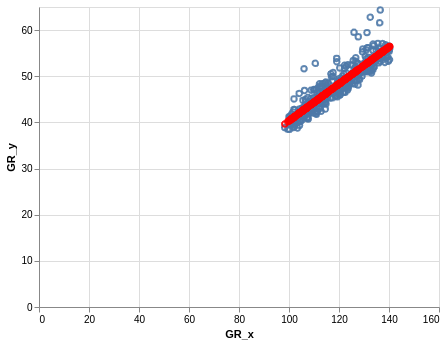

In [143]:
# For test
df_test = pd.read_csv('../data/raw/test_lofi_rowid_Nov13.csv')
x_up = df_test.groupby('well_id')['GR'].quantile(0.715)
x_down = df_test.groupby('well_id')['GR'].quantile(0.095)
df_joint = pd.merge(x_up.reset_index(),x_down.reset_index(),on='well_id',how='right',suffixes =['_x','_y']).dropna()
df_joint_fake = pd.DataFrame({'GR_x':x_up.values,'GR_y':0.4*x_up.values + 0.33})
ch_joint = alt.Chart(df_joint).encode(x='GR_x',y='GR_y',tooltip=['well_id']).mark_point(opacity=0.9)
ch_joint_fake = alt.Chart(df_joint_fake).encode(x='GR_x',y='GR_y',color=alt.value('red')).mark_point(opacity=0.9)
ch_joint + ch_joint_fake


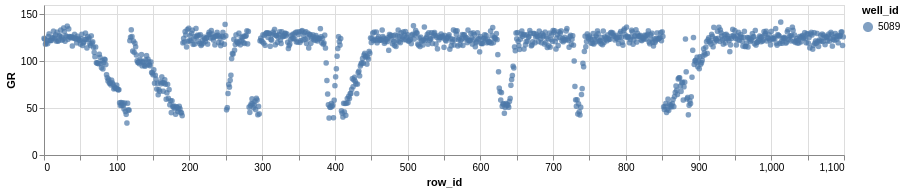

In [149]:
df_sub_test = df_test[df_test['well_id'] == 5089]
ch_gr = alt.Chart(df_sub_test,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='well_id:N').mark_point(size=30,filled=True)
ch_gr

In [242]:
##### x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].median()
well_ids = df_train['well_id'].sample(4,random_state=13).unique()

x0 = df_train[df_train['label']==0].groupby('well_id')['GR'].median()[well_ids].to_frame()
x2 = df_train[df_train['label']==2].groupby('well_id')['GR'].median()[well_ids].to_frame()

df_train_new = df_train[df_train['well_id'].isin(well_ids)]
df_train_new = pd.merge(df_train_new,x0.reset_index(),on='well_id',suffixes=('','_0'))#.drop(columns ='well_id_0')
df_train_new = pd.merge(df_train_new,x2.reset_index(),on='well_id',suffixes=('','_2'))#.drop(columns ='well_id_0')
df_train_new

row_id  well_id          GR  label        GR_0       GR_2
0          0     1401  116.443801      0  114.139582  46.743629
1          1     1401  108.069501      0  114.139582  46.743629
2          2     1401  109.032034      0  114.139582  46.743629
3          3     1401  116.127672      0  114.139582  46.743629
4          4     1401  109.509742      0  114.139582  46.743629
...      ...      ...         ...    ...         ...        ...
4395    1095     2905  136.198745      0  137.816364  55.733522
4396    1096     2905  137.287788      0  137.816364  55.733522
4397    1097     2905  137.973630      0  137.816364  55.733522
4398    1098     2905  131.373258      0  137.816364  55.733522
4399    1099     2905  139.552631      0  137.816364  55.733522

[4400 rows x 6 columns]

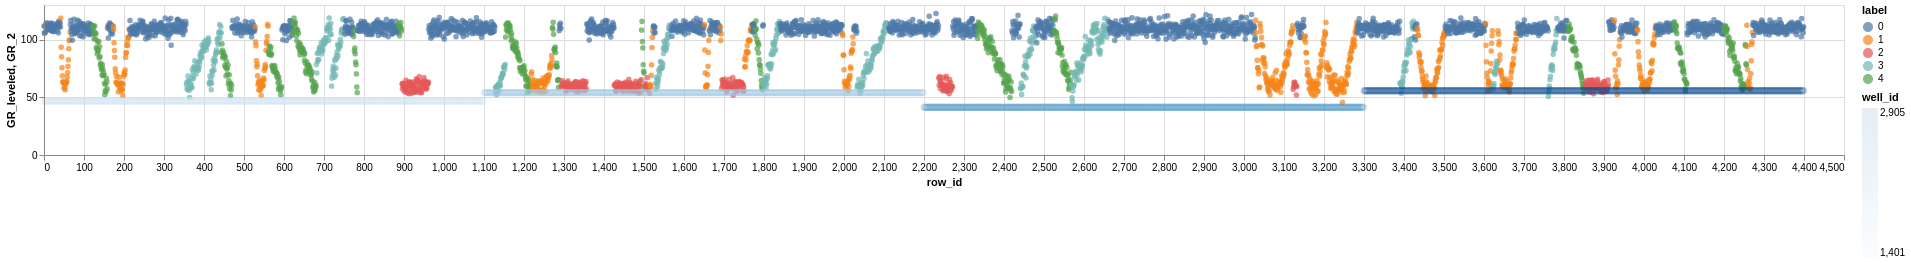

In [244]:
df_train_new['scale'] = (z0-z2)/(df_train_new['GR_0'] - df_train_new['GR_2'])

z0,z2=110,60
scale = (z0-z2)/(df_train_new['GR_0'] - df_train_new['GR_2'])

df_train_new['GR_leveled'] = (df_train_new['GR'] - df_train_new['GR_2'])*scale+z2

df_sub = df_train_new[df_train_new['well_id'].isin(well_ids)].copy()
df_sub['row_id'] = np.arange(df_sub.shape[0])

ch_gr = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR_leveled',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch20 = alt.Chart(df_sub,height =600,width=600).encode(x='row_id',y='GR_2',order='row_id',color='well_id').mark_point(size=30,opacity=0.1)
#ch20
ch_gr+ch20
#df_train_new[df_train_new['label']==2].groupby(['well_id'])['GR_leveled'].mean().plot()
#df_sub[df_sub['label']==2].groupby(['well_id'])['GR_leveled'].median()
#df_train[df_train['label']==0].groupby('well_id')['GR'].mean().to_frame()


In [177]:
df_train_new.to_pickle('../data/processed/df_normalized.pck')


In [178]:
%matplotlib inline

# Check the sliced data

/home/geoanton/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


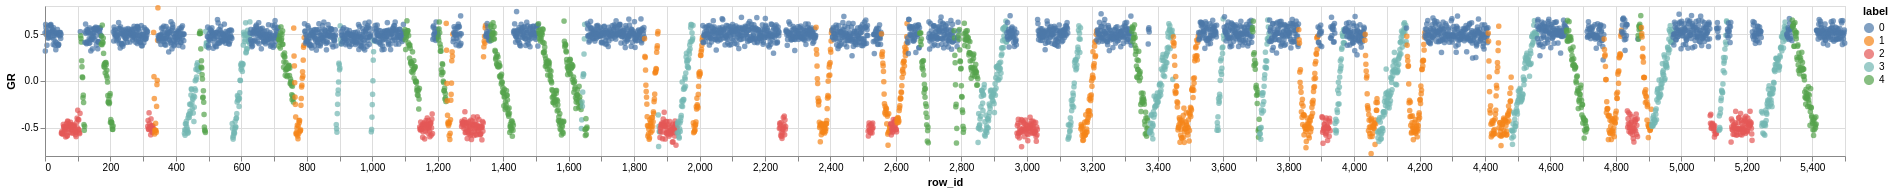

In [37]:
df_sliced = pd.read_pickle('../data/processed/df_normalized_script.pck')

well_ids = df_sliced['well_id'].sample(100).unique()[:5]
df_sub = df_sliced[df_sliced['well_id'].isin(well_ids)]
df_sub['row_id'] = np.arange(df_sub.shape[0])
#df_sub['GR'] = (df_sub['GR']-df_sub['GR'].mean())/df_sub['GR'].std()

ch_gr = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
#ch_grp = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='pred:N').mark_point(size=30,filled=True)
#ch_gr_g2 = alt.Chart(df_sub,height=150,width=1800).encode(x='row_id',y='GR',order='row_id').mark_point(size=30,filled=True)

#ch_pred = alt.Chart(df_sub,height=150,width=800).encode(x='row_id',y='pred',order='row_id',color='pred:N').mark_point()
#mu0 = df_sub[df_sub['label']==2]['GR_leveled'].median()
ch_gr
#df_sub[df_sub['label']==0].groupby(['well_id'])['GR'].median()
#(ch_gr + ch_gr_g2 ) 

# Build a correlation matrix

In [27]:
a = df_test[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
a.columns = np.arange(a.shape[1])
b = df_test_cax[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
b.columns = np.arange(b.shape[1])+a.shape[1]+1
c = df_train[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
c.columns = np.arange(c.shape[1])+a.shape[1]+b.shape[1]+1
d = df_train_cax[['well_id','GR','row_id']].pivot(columns='well_id',values='GR',index='row_id')
d.columns = np.arange(d.shape[1])+a.shape[1]+b.shape[1]+c.shape[1]+1
all_df =pd.concat([a,b,c,d],axis=1)

In [113]:
%matplotlib inline
cm = np.corrcoef(all_df.values,rowvar=False)
for i in range(cm.shape[0]):
    cm[i,i] = 0
b = np.max(cm,axis=1)

In [60]:
from scipy.signal import medfilt
x = df_train[df_train['label']==4]['GR'].diff().values
np.nanstd(x)

12.818672373586598

## Figure out if the depth reference point is common, or tied to surface.
1. Looks like the reference is not globally defined, i.e. the 0 depth is at surface. :(
2. The wells have a consistent length (all have 1100 points). So maybe the geological model is flat-surfaced..?


In [121]:
df_train.groupby('well_id').size().describe()

count    4000.0
mean     1100.0
std         0.0
min      1100.0
25%      1100.0
50%      1100.0
75%      1100.0
max      1100.0
dtype: float64

Lets plot a few wells with close `well_id` together in a section

/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


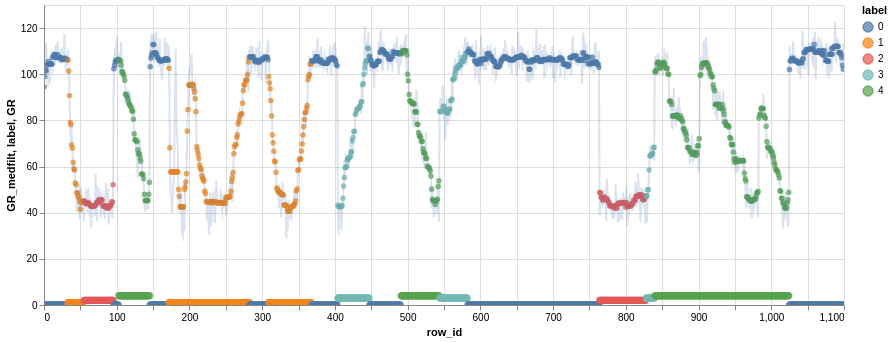

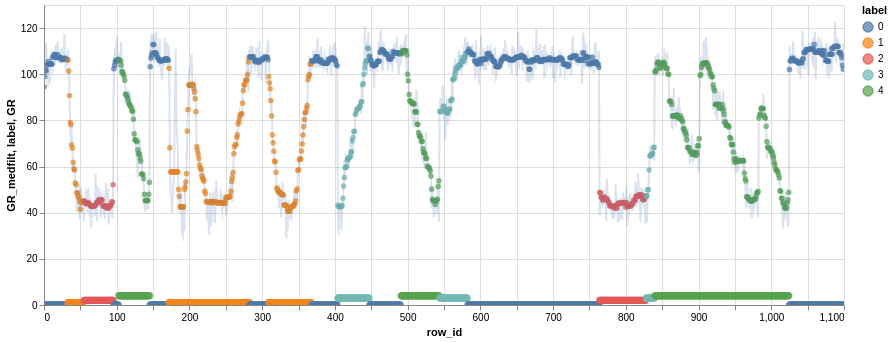

In [132]:
h=300
well_ids = df_train['well_id'].unique()[0]
df_sub = df_train[df_train['well_id'] == well_ids]
df_sub['GR_medfilt'] = medfilt(df_sub['GR'],11)
ch_gr = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point().interactive()
ch_line = alt.Chart(df_sub,height=h,width=800).encode(x='row_id',y='GR',order='row_id').mark_line(opacity=0.2)
ch_gr + ch_lab + ch_line

# Try playing with KDTree

In [67]:
from scipy.signal import medfilt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def cut_window(data_cycle, overlap=0.0, base_length=96):
    """
    Function for fancy numpy indexing
    :param data_cycle:
    :type data_cycle:
    :param overlap:
    :type overlap:
    :param base_length:
    :type base_length:
    :return:
    :rtype:
    """
    step = int((1 - overlap) * base_length)
    n_windows = np.ceil((data_cycle.shape[0] - base_length) / step)
    indexer = np.arange(base_length)[None, :] + step * np.arange(n_windows)[:, None]
    return indexer.astype('int'), int(n_windows)

def get_a_NN_object(df, n_wells_start, n_wells_end=2000, window_length=45):
    df['GR_medfilt'] = medfilt(df['GR'], 31)
    well_ids = df['well_id'].unique().tolist()[n_wells_start:(n_wells_start + n_wells_end)]
    df_wells = df[df['well_id'].isin(well_ids)]
    idxr, n_wins = cut_window(df_wells['GR_medfilt'], overlap=0.8, base_length=window_length)
    windows = df_wells['GR_medfilt'].values[idxr]
    labels = df_wells['label'].values[idxr]
    NN = NearestNeighbors(n_neighbors=10, metric='braycurtis')
    NN.fit(windows)
    return NN, labels


def augment_a_well_nearest_neighbors(df, NN, labels, bl=40):
    df_tmp = df.copy()
    df_tmp['GR_nn'] = medfilt(df['GR'], 31)
    idxr, n_win = cut_window(df_tmp['GR_nn'].values, overlap=0.0, base_length=bl)
    windows = df_tmp['GR_nn'].values[idxr]
    dist, idw = NN.kneighbors(windows, n_neighbors=5)
    dist_flip, idw_flip = NN.kneighbors(np.fliplr(windows), n_neighbors=5)

    pred = mode(labels[idw, :], axis=1)[0]
    pred = pred.reshape(pred.shape[0], pred.shape[2]).flatten()

    pred_lr = mode(labels[idw_flip, :], axis=1)[0]
    pred_lr = pred_lr.reshape(pred_lr.shape[0], pred_lr.shape[2])

    df_labels_windows = pd.DataFrame(
        {'row_id': idxr.flatten(), f'label_nn_{bl}': pred, f'flip_same_{bl}': np.equal(pred, pred_lr.flatten()),
         f'same_after_inv_{bl}': np.equal(pred, np.fliplr(pred_lr).flatten())})
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_tmp.join(res, on='row_id', rsuffix='_r').drop(columns=['row_id_r', 'GR_nn'])
    return res

df_train['GR_medfilt'] = medfilt(df_train['GR'],31)
window_length = 35

wells_test = df_train['well_id'].unique()[3900:3950]
df_wells_test =  df_train[df_train['well_id'].isin(wells_test)]
NN_list,labels_list = [],[]
NN, labels = get_a_NN_object(df_train,n_wells_start=0,n_wells_end=400,window_length=window_length)


df_wells_test_dict  = dict(zip(wells_test,[df_train[df_train['well_id'] ==w] for w in wells_test]))
df_wells_test_augmented =[augment_a_well_nearest_neighbors(df,NN,labels,bl=window_length) for df in df_wells_test_dict.values()]

In [68]:
df_all_test = pd.concat(df_wells_test_augmented,axis=0).dropna()
print(accuracy_score(df_all_test['label'],df_all_test[f'label_nn_{window_length}']))

0.8731981566820276


0.89096


In [7]:
%matplotlib inline
tmp = df_train[df_train['well_id'].isin([17])]
def augment_a_well_nearest_neighbors(df,NN,labels,bl=50):
    from scipy.stats import mode
    idxr,n_win = cut_window(df['GR_medfilt'].values,overlap=0.0,base_length=bl)
    windows = df['GR_medfilt'].values[idxr]
    print(idxr)
    dist,idw = NN.kneighbors(windows,n_neighbors=5)
    pred =mode(labels[idw,:],axis=1)[0]
    pred = pred.reshape(pred.shape[0],pred.shape[2])
    print(pred.shape)
    #true_labels = df['label'].values[idxr].flatten()
    res=None
    df_labels_windows = pd.DataFrame({'row_id':idxr.flatten(),'label_nn':pred.flatten()})
    #df_labels_windows = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df_labels_windows.groupby('row_id').mean().reset_index()
    res = df.copy().join(res,on='row_id',rsuffix='_r').drop(columns = 'row_id_r')
    return res


def divide_block_steps(df,t=24):
    df['step'] = (df['GR'].diff().abs() >= t)
    df_steps = df[df['step']]
    
    inds = np.hstack([0,np.array(df_steps['row_id']),df['row_id'].max()+1])
    counts = np.zeros(df.shape[0])
    counts[:inds[0]] = np.arange(inds[0])
    res = np.ones(df.shape[0])
    for i in range(len(inds) - 1):
        res[inds[i]:inds[i + 1]] = i
        counts[inds[i]:inds[i + 1]] = np.arange(inds[i + 1] - inds[i])
    
    df['prev_val_step'] = np.nan
    df.loc[df['step'],'prev_val_step'] = df['GR'].diff()
    df['prev_val_step'] = df['prev_val_step'].fillna(method = 'ffill').astype('float')
    
    df['next_val_step'] = np.nan
    df.loc[df['step'],'next_val_step'] = df['GR'].diff()
    df['next_val_step'] = df['next_val_step'].fillna(method ='bfill').astype('float')    
        
    df['count_step'] = counts
    df['count_groups'] = res
    df['count_step_norm'] = df['count_step']/df.groupby('count_groups')['count_step'].transform('max')
    
    return df

df_preds = augment_a_well_nearest_neighbors(tmp,NN,labels,bl=window_length).dropna()
df_preds['grp'] = (df_preds['label_nn']!=df_preds['label_nn'].shift(1)).cumsum()
df_preds = divide_block_steps(df_preds,20)

ch_gr = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='GR',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_preds,height=150,width=800).encode(x='row_id',y='count_groups',order='row_id',color='label_nn:N').mark_point()
#ch_steps = alt.Chart(df_steps,height=150,width=800).encode(x='row_id').mark_rule()

(ch_gr) & (ch_lab)

NameError: name 'NN' is not defined

# Prototype a few functions:

In [6]:
from sklearn.linear_model import LinearRegression
def diff_sum(x):
    res = np.diff(x).sum()
    return res
def abs_diff_sum(x):
    res = np.abs(np.diff(x)).sum()
    return res

def rolling_slope(x):
    model_ols =LinearRegression()
    idx=np.arange(x.shape[0])
    model_ols.fit(idx.reshape(-1, 1), x.reshape(-1, 1))
    res = model_ols.coef_[0]
    return res

    
def apply_rolling_functions(df,col='GR',window=10,func ={'mean':np.mean,'std':np.std,'diff_sum':diff_sum,'abs_diff_sum':abs_diff_sum,'slope':rolling_slope}):
    names =[]
    for k,v in func.items():
        series = df[col].rolling(window=window,center=True,min_periods=1).apply(v,raw=True)
        colname = f'{k}_{window}_{col}'
        df.loc[:,colname] = series.values
        names.append(colname)
    df.index = np.arange(df.shape[0])
    return df[names]
def preprocess_a_well(df_well):
    df_feats_w20 = apply_rolling_functions(df_well,window=20)
    df_feats_w60 = apply_rolling_functions(df_well,window=60)
    df_feats_w150 = apply_rolling_functions(df_well,window=150)
    df_feats = pd.concat([df_well,df_feats_w20,df_feats_w60,df_feats_w150],axis=1)
    return df_feats
